<a href="https://colab.research.google.com/github/CallSohail/Text-Emotion-Gap/blob/main/Multi_Label_Emotion_Classification_in_Text_Using_XLM_Roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries for Emotion Detection Pipeline**

- **Data manipulation and visualization:** pandas, numpy, matplotlib, seaborn.
- **Text preprocessing:** nltk for lemmatization and stopword removal, re for text cleaning.
- **Modeling:** transformers for XLM-Roberta, torch for deep learning.
- **Metrics and evaluation:** sklearn and custom evaluation functions.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.corpus import wordnet
import nltk
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.cuda.amp import GradScaler, autocast


In [2]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Text Preprocessing: `preprocess_text` Function**

- **Purpose:** Cleans and standardizes input text for machine learning tasks.  
- **Key Steps:**
  - Converts text to **lowercase** for uniformity.
  - Removes special characters using `re.sub` to retain only alphabetic content.
  - Filters out **stopwords** using `nltk.corpus.stopwords`.
  - Applies **lemmatization** with `WordNetLemmatizer` to reduce words to their base forms.
  - Joins cleaned words into a single string, ready for modeling or analysis.


In [5]:
# Step 1: Define all your functions
# Function to preprocess text
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))  # Adjust for language if needed
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# **Text Augmentation: `synonym_replacement` Function**

- **Purpose:** Enhances text data by replacing words with their synonyms, helping to expand the dataset for better generalization.  
- **Key Steps:**
  - Splits the input `text` into individual words.  
  - Identifies words with **synonyms** using `wordnet.synsets` from NLTK.  
  - Randomly selects words and replaces up to `n` of them with their first available synonym.  
  - Reconstructs the modified word list into a single string and returns it.  



In [6]:
# Function to augment text using synonyms
def synonym_replacement(text, n):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

In [ ]:
# Loop over all CSV files in the 'train' folder and process each language
train_folder = '/content/drive/MyDrive/public_data_dev/track_a/train'

In [ ]:
# Emotion columns
emotion_columns = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]

In [ ]:
# Loop through all CSV files in the directory
for filename in os.listdir(train_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(train_folder, filename)

        # Load the CSV file into a pandas DataFrame
        data = pd.read_csv(file_path)

        # Get the number of rows and columns
        num_rows, num_columns = data.shape

        # Extract the language name from the filename
        language_name = filename.replace('.csv', '')

        # Print the results
        print(f"{language_name}: {num_rows} rows, {num_columns} columns")

sun: 924 rows, 8 columns
chn: 2642 rows, 8 columns
orm: 3442 rows, 8 columns
tir: 3681 rows, 8 columns
swe: 1187 rows, 8 columns
rus: 2679 rows, 8 columns
ptbr: 2226 rows, 8 columns
arq: 901 rows, 8 columns
ukr: 2466 rows, 8 columns
mar: 2415 rows, 8 columns
ptmz: 1546 rows, 8 columns
deu: 2603 rows, 8 columns
vmw: 1551 rows, 8 columns
ibo: 2880 rows, 8 columns
pcm: 3728 rows, 8 columns
esp: 1996 rows, 8 columns
amh: 3549 rows, 8 columns
swa: 3307 rows, 8 columns
hau: 2145 rows, 8 columns
hin: 2556 rows, 8 columns
tat: 1000 rows, 8 columns
yor: 2992 rows, 8 columns
kin: 2451 rows, 8 columns
ary: 1608 rows, 8 columns
som: 3392 rows, 8 columns


# **Pipeline for Multi-Language Emotion Detection**

The code implements a **complete pipeline** for detecting emotions in text data across multiple languages. It includes data loading, preprocessing, augmentation, resampling, model training, and evaluation using the **XLM-Roberta** model.  

- **File Handling:** Loops through `.csv` language files in the specified folder, loading datasets for analysis and processing.  
- **Exploratory Data Analysis (EDA):** Prints dataset summaries, missing values, and visualizes correlations using a heatmap.  
- **Text Augmentation:** Augments text data using the `synonym_replacement` function to create synthetic samples.  
- **Text Preprocessing:** Cleans and prepares text for modeling using the `preprocess_text` function.  
- **Data Balancing:** Resamples classes to handle imbalances, ensuring equal representation for all emotion labels.  
- **Train-Test Split:** Splits the balanced dataset into training and testing subsets.  
- **Tokenization:** Uses Hugging Face's `XLMRobertaTokenizer` to tokenize text data for the transformer model.  
- **Model Training:** Fine-tunes `XLM-Roberta` on the training set using a custom training loop with the AdamW optimizer.  
- **Evaluation:** Computes **F1 Score** and **Accuracy** on the test set to assess performance.  
- **Model Saving:** Saves the trained model and tokenizer for each language file to a dedicated directory for reuse.  


Processing language file: sun.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        924 non-null    object
 1   text      924 non-null    object
 2   anger     924 non-null    int64 
 3   disgust   924 non-null    int64 
 4   fear      924 non-null    int64 
 5   joy       924 non-null    int64 
 6   sadness   924 non-null    int64 
 7   surprise  924 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 57.9+ KB
None

Missing Values (in Percentage):
id          0.0
text        0.0
anger       0.0
disgust     0.0
fear        0.0
joy         0.0
sadness     0.0
surprise    0.0
dtype: float64


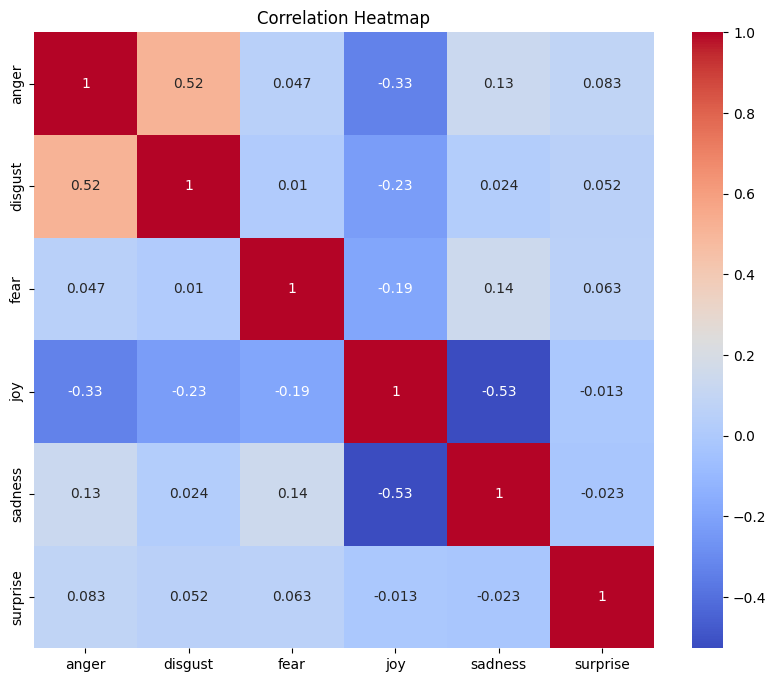


Emotion Counts:
anger        84
disgust      68
fear         47
joy         672
sadness     212
surprise    226
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.6358624842054773
Epoch 2/5: Training Loss: 0.42553321991374
Epoch 3/5: Training Loss: 0.24726864651288136
Epoch 4/5: Training Loss: 0.1513680734459569
Epoch 5/5: Training Loss: 0.09048206688338283
Test Accuracy: 0.5997521685254027
Test F1 Score: 0.47634546177643916
Model and tokenizer saved to /content/Model_sun
Processing language file: chn.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2642 entries, 0 to 2641
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2642 non-null   object
 1   text      2642 non-null   object
 2   anger     2642 non-null   int64 
 3   disgust   2642 non-null   int64 
 4   fear      2642 non-null   int64 
 5   joy       2642 non-null   int64 
 6   sadness   2642 non-null   int64 
 7   surprise  2642 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 165.2+ KB
None

Missing Values (in Percentage):
id          0.0
text        0.

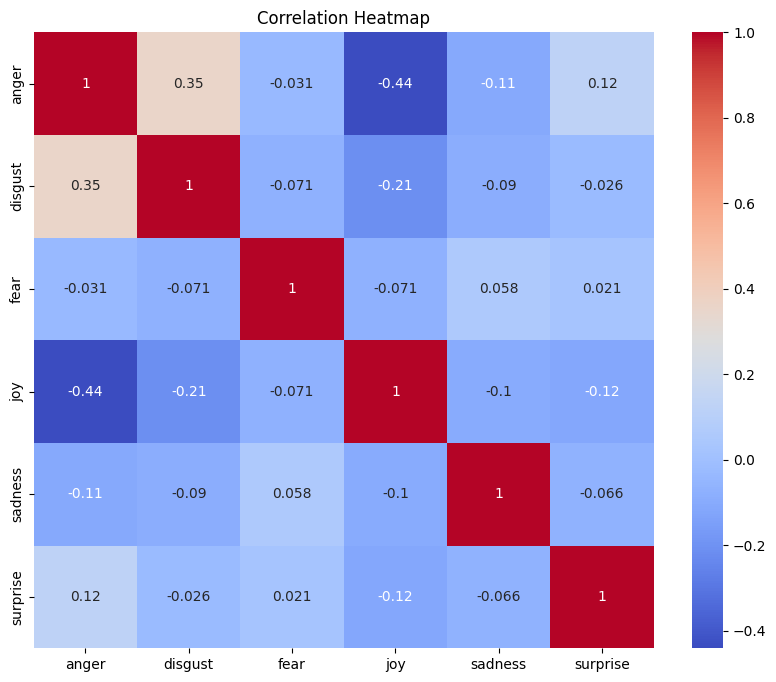


Emotion Counts:
anger       1178
disgust      403
fear          71
joy          529
sadness      354
surprise     178
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.3843026661130967
Epoch 2/5: Training Loss: 0.1689300741394389
Epoch 3/5: Training Loss: 0.090716385913557
Epoch 4/5: Training Loss: 0.05219275718014766
Epoch 5/5: Training Loss: 0.03339023178751558
Test Accuracy: 0.7326732673267327
Test F1 Score: 0.6765676392764264
Model and tokenizer saved to /content/Model_chn
Processing language file: orm.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3442 entries, 0 to 3441
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3442 non-null   object
 1   text      3442 non-null   object
 2   anger     3442 non-null   int64 
 3   disgust   3442 non-null   int64 
 4   fear      3442 non-null   int64 
 5   joy       3442 non-null   int64 
 6   sadness   3442 non-null   int64 
 7   surprise  3442 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 215.2+ KB
None

Missing Values (in Percentage):
id          0.0
text        0.

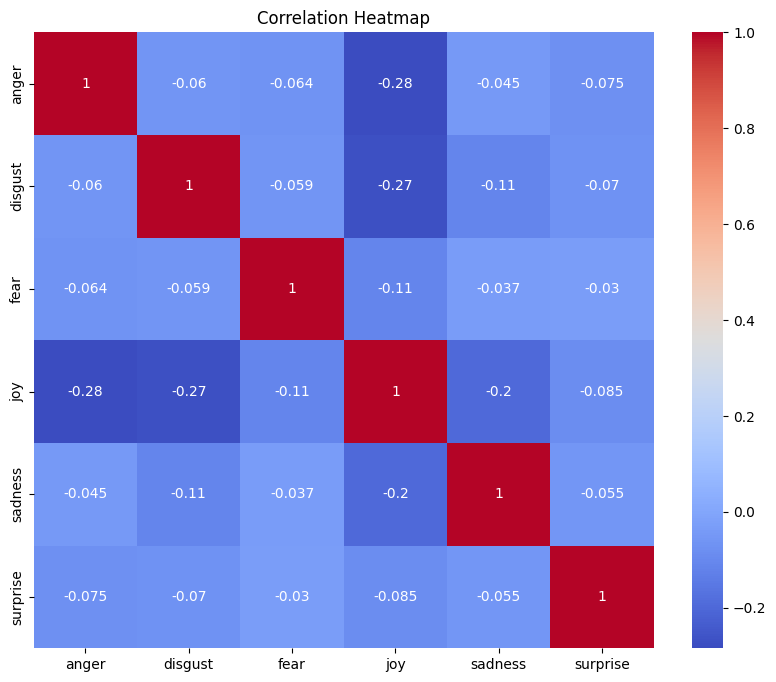


Emotion Counts:
anger        646
disgust      557
fear         123
joy         1091
sadness      298
surprise     129
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.4756509427350896
Epoch 2/5: Training Loss: 0.3604857967100071
Epoch 3/5: Training Loss: 0.24512991925118532
Epoch 4/5: Training Loss: 0.1595699388903516
Epoch 5/5: Training Loss: 0.11129610181594168
Test Accuracy: 0.8282442748091603
Test F1 Score: 0.8343293820192011
Model and tokenizer saved to /content/Model_orm
Processing language file: tir.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3681 entries, 0 to 3680
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3681 non-null   object
 1   text      3681 non-null   object
 2   anger     3681 non-null   int64 
 3   disgust   3681 non-null   int64 
 4   fear      3681 non-null   int64 
 5   joy       3681 non-null   int64 
 6   sadness   3681 non-null   int64 
 7   surprise  3681 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 230.2+ KB
None

Missing Values (in Percentage):
id          0.0
text        0

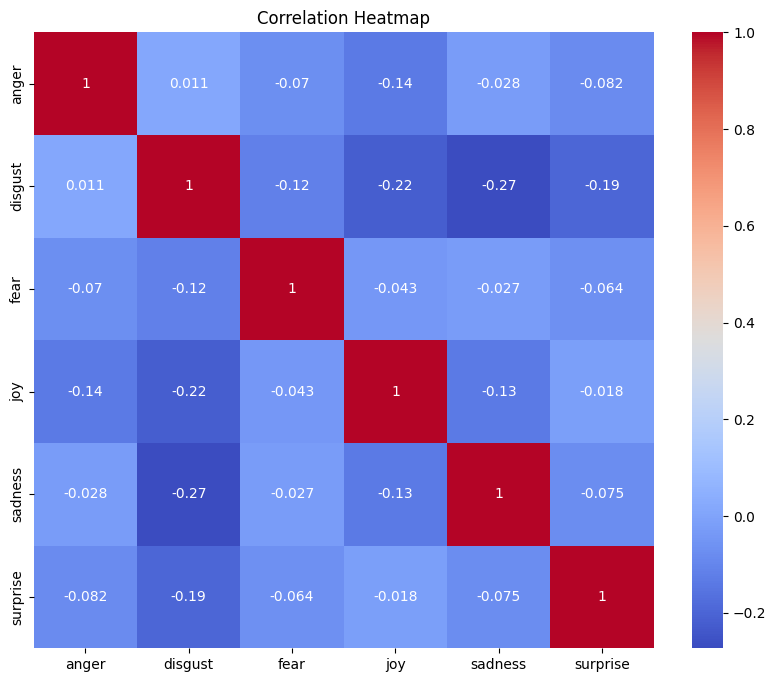


Emotion Counts:
anger        547
disgust     1311
fear         138
joy          417
sadness      588
surprise     355
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.5049538233304418
Epoch 2/5: Training Loss: 0.40330311975985045
Epoch 3/5: Training Loss: 0.311276529159449
Epoch 4/5: Training Loss: 0.24368985930725157
Epoch 5/5: Training Loss: 0.19140636246873888
Test Accuracy: 0.7090216010165185
Test F1 Score: 0.7091838992729143
Model and tokenizer saved to /content/Model_tir
Processing language file: swe.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187 entries, 0 to 1186
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1187 non-null   object
 1   text      1187 non-null   object
 2   anger     1187 non-null   int64 
 3   disgust   1187 non-null   int64 
 4   fear      1187 non-null   int64 
 5   joy       1187 non-null   int64 
 6   sadness   1187 non-null   int64 
 7   surprise  1187 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 74.3+ KB
None

Missing Values (in Percentage):
id          0.0
text        0.

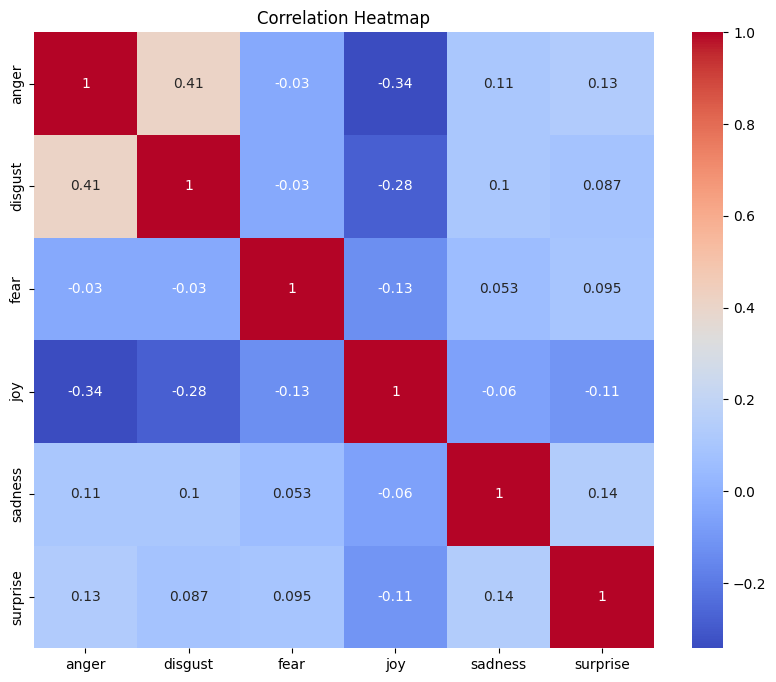


Emotion Counts:
anger       247
disgust     210
fear         36
joy         502
sadness     122
surprise     59
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.5560999596553133
Epoch 2/5: Training Loss: 0.36151101030656047
Epoch 3/5: Training Loss: 0.23282061566580212
Epoch 4/5: Training Loss: 0.13204838859768497
Epoch 5/5: Training Loss: 0.07430632777561415
Test Accuracy: 0.5837479270315091
Test F1 Score: 0.5648249171622289
Model and tokenizer saved to /content/Model_swe
Processing language file: rus.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679 entries, 0 to 2678
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2679 non-null   object
 1   text      2679 non-null   object
 2   anger     2679 non-null   int64 
 3   disgust   2679 non-null   int64 
 4   fear      2679 non-null   int64 
 5   joy       2679 non-null   int64 
 6   sadness   2679 non-null   int64 
 7   surprise  2679 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 167.6+ KB
None

Missing Values (in Percentage):
id          0.0
text       

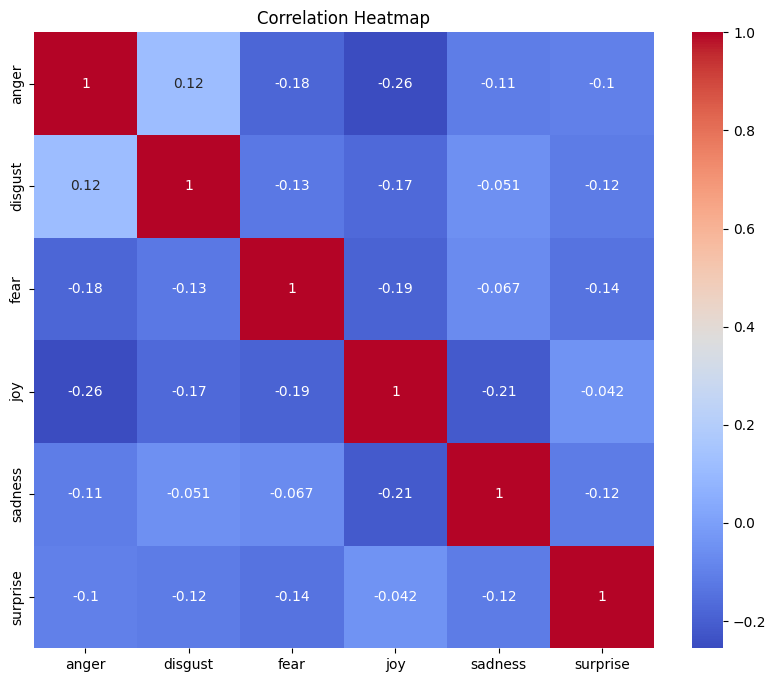


Emotion Counts:
anger       543
disgust     273
fear        328
joy         555
sadness     421
surprise    355
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.4871162035622754
Epoch 2/5: Training Loss: 0.2726133649234657
Epoch 3/5: Training Loss: 0.17803122539509525
Epoch 4/5: Training Loss: 0.11697736918344512
Epoch 5/5: Training Loss: 0.08252557369323822
Test Accuracy: 0.7732732732732732
Test F1 Score: 0.7709193841391668
Model and tokenizer saved to /content/Model_rus
Processing language file: ptbr.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2226 non-null   object
 1   text      2226 non-null   object
 2   anger     2226 non-null   int64 
 3   disgust   2226 non-null   int64 
 4   fear      2226 non-null   int64 
 5   joy       2226 non-null   int64 
 6   sadness   2226 non-null   int64 
 7   surprise  2226 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 139.2+ KB
None

Missing Values (in Percentage):
id          0.0
text       

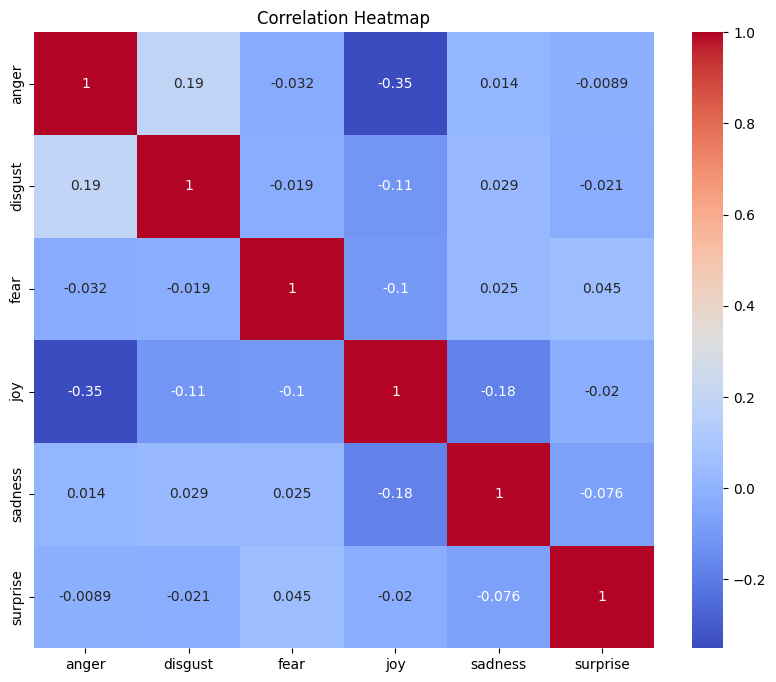


Emotion Counts:
anger       718
disgust      75
fear        109
joy         581
sadness     322
surprise    153
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.5143516523517202
Epoch 2/5: Training Loss: 0.3296339834787453
Epoch 3/5: Training Loss: 0.19137815505335337
Epoch 4/5: Training Loss: 0.10370814765688992
Epoch 5/5: Training Loss: 0.06526659308066224
Test Accuracy: 0.679814385150812
Test F1 Score: 0.6583084108899461
Model and tokenizer saved to /content/Model_ptbr
Processing language file: arq.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        901 non-null    object
 1   text      901 non-null    object
 2   anger     901 non-null    int64 
 3   disgust   901 non-null    int64 
 4   fear      901 non-null    int64 
 5   joy       901 non-null    int64 
 6   sadness   901 non-null    int64 
 7   surprise  901 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 56.4+ KB
None

Missing Values (in Percentage):
id          0.0
text        0.0

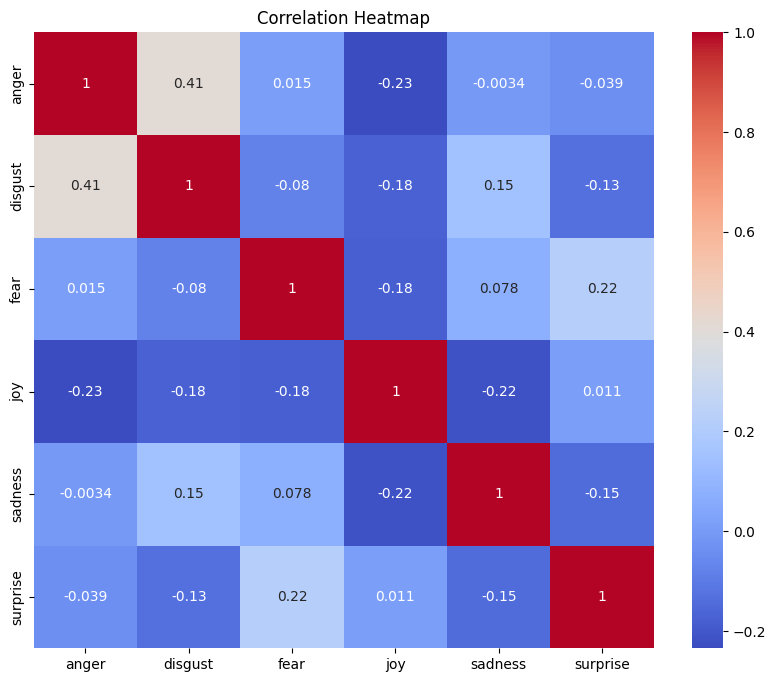


Emotion Counts:
anger       296
disgust     206
fear        223
joy         153
sadness     404
surprise    313
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.6541037255353889
Epoch 2/5: Training Loss: 0.5985034201370836
Epoch 3/5: Training Loss: 0.47051410088813844
Epoch 4/5: Training Loss: 0.3557269139054381
Epoch 5/5: Training Loss: 0.26705830124180013
Test Accuracy: 0.4762886597938144
Test F1 Score: 0.34976218246004304
Model and tokenizer saved to /content/Model_arq
Processing language file: ukr.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2466 non-null   object
 1   text      2466 non-null   object
 2   anger     2466 non-null   int64 
 3   disgust   2466 non-null   int64 
 4   fear      2466 non-null   int64 
 5   joy       2466 non-null   int64 
 6   sadness   2466 non-null   int64 
 7   surprise  2466 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 154.2+ KB
None

Missing Values (in Percentage):
id          0.0
text        

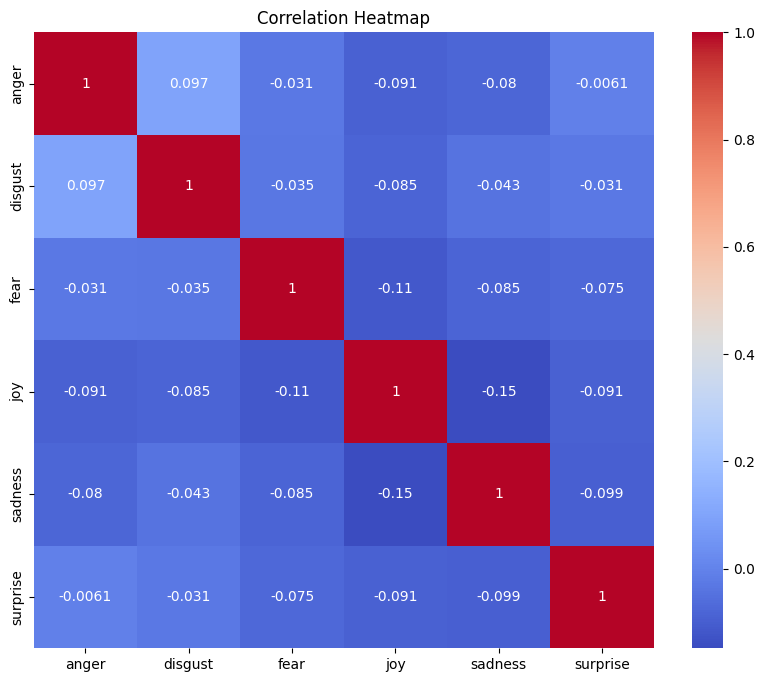


Emotion Counts:
anger        98
disgust      86
fear        172
joy         412
sadness     333
surprise    196
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.5094592907736378
Epoch 2/5: Training Loss: 0.4556618967363911
Epoch 3/5: Training Loss: 0.33478063849672196
Epoch 4/5: Training Loss: 0.21056322627250226
Epoch 5/5: Training Loss: 0.1320968499527343
Test Accuracy: 0.8686868686868687
Test F1 Score: 0.867206602346776
Model and tokenizer saved to /content/Model_ukr
Processing language file: mar.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2415 entries, 0 to 2414
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2415 non-null   object
 1   text      2415 non-null   object
 2   anger     2415 non-null   int64 
 3   disgust   2415 non-null   int64 
 4   fear      2415 non-null   int64 
 5   joy       2415 non-null   int64 
 6   sadness   2415 non-null   int64 
 7   surprise  2415 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 151.1+ KB
None

Missing Values (in Percentage):
id          0.0
text        0.

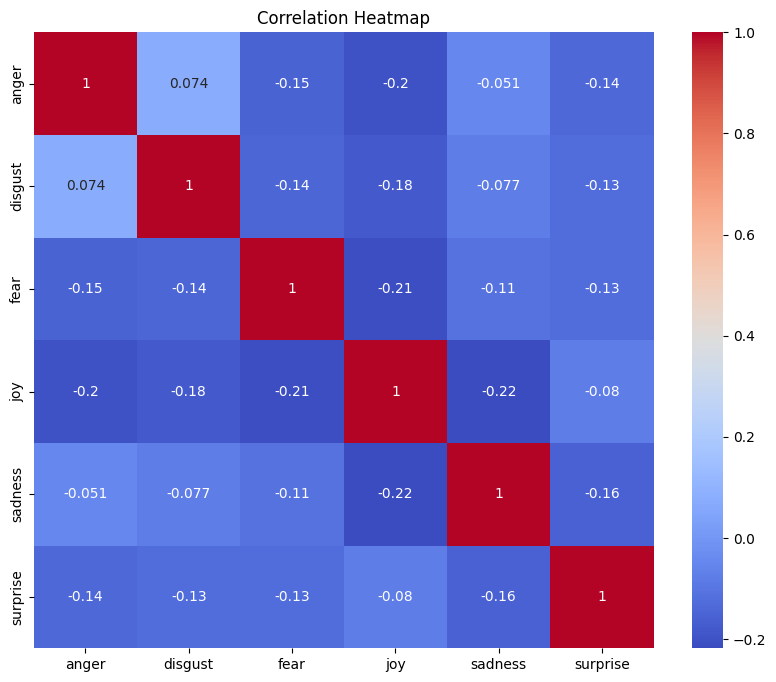


Emotion Counts:
anger       350
disgust     299
fear        382
joy         461
sadness     431
surprise    311
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.5072349371247343
Epoch 2/5: Training Loss: 0.31652252532084496
Epoch 3/5: Training Loss: 0.1850841759236711
Epoch 4/5: Training Loss: 0.12669236936508962
Epoch 5/5: Training Loss: 0.09316658450539361
Test Accuracy: 0.855595667870036
Test F1 Score: 0.8608054321443301
Model and tokenizer saved to /content/Model_mar
Processing language file: ptmz.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1546 non-null   object
 1   text      1546 non-null   object
 2   anger     1546 non-null   int64 
 3   disgust   1546 non-null   int64 
 4   fear      1546 non-null   int64 
 5   joy       1546 non-null   int64 
 6   sadness   1546 non-null   int64 
 7   surprise  1546 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 96.8+ KB
None

Missing Values (in Percentage):
id          0.0
text        0

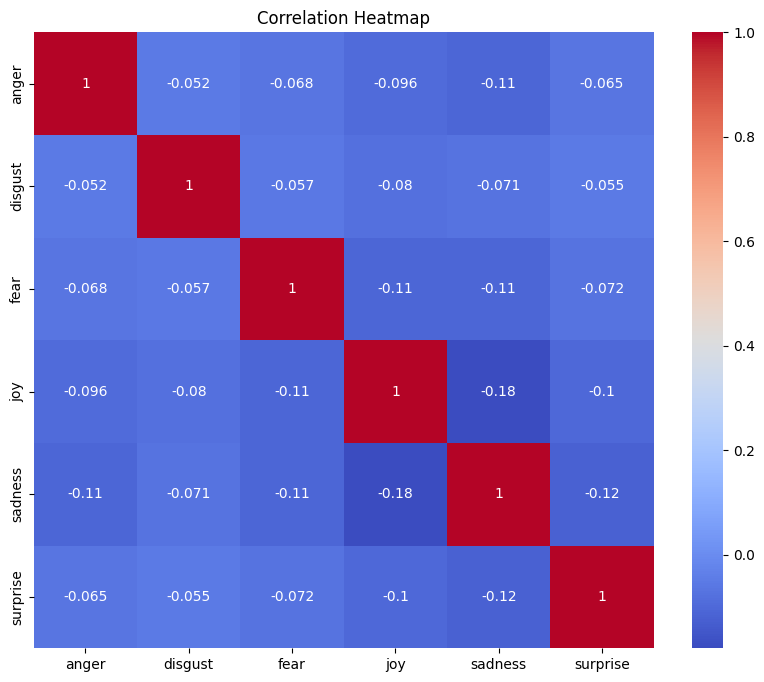


Emotion Counts:
anger        90
disgust      64
fear        109
joy         199
sadness     276
surprise    100
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.5022403326738312
Epoch 2/5: Training Loss: 0.41809443393385554
Epoch 3/5: Training Loss: 0.3296035108077957
Epoch 4/5: Training Loss: 0.23808566705290093
Epoch 5/5: Training Loss: 0.1548889972359301
Test Accuracy: 0.8975903614457831
Test F1 Score: 0.8983365890960888
Model and tokenizer saved to /content/Model_ptmz
Processing language file: deu.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2603 non-null   object
 1   text      2603 non-null   object
 2   anger     2603 non-null   int64 
 3   disgust   2603 non-null   int64 
 4   fear      2603 non-null   int64 
 5   joy       2603 non-null   int64 
 6   sadness   2603 non-null   int64 
 7   surprise  2603 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 162.8+ KB
None

Missing Values (in Percentage):
id          0.0
text        

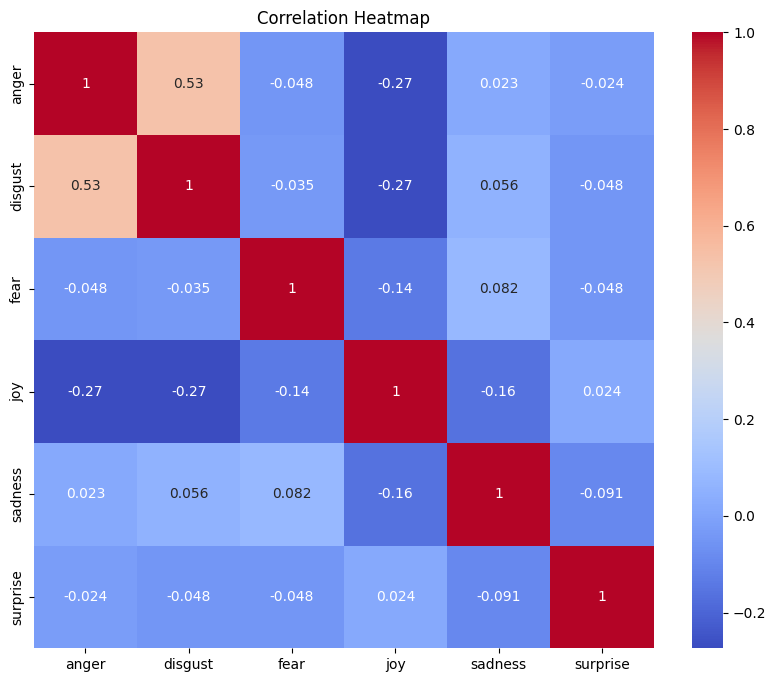


Emotion Counts:
anger       768
disgust     832
fear        239
joy         541
sadness     516
surprise    159
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.5125122014284134
Epoch 2/5: Training Loss: 0.33966584466397765
Epoch 3/5: Training Loss: 0.22482115118205548
Epoch 4/5: Training Loss: 0.15138594207912684
Epoch 5/5: Training Loss: 0.10509225605800748
Test Accuracy: 0.5445445445445446
Test F1 Score: 0.5297510576198506
Model and tokenizer saved to /content/Model_deu
Processing language file: vmw.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551 entries, 0 to 1550
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1551 non-null   object
 1   text      1551 non-null   object
 2   anger     1551 non-null   int64 
 3   disgust   1551 non-null   int64 
 4   fear      1551 non-null   int64 
 5   joy       1551 non-null   int64 
 6   sadness   1551 non-null   int64 
 7   surprise  1551 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 97.1+ KB
None

Missing Values (in Percentage):
id          0.0
text        

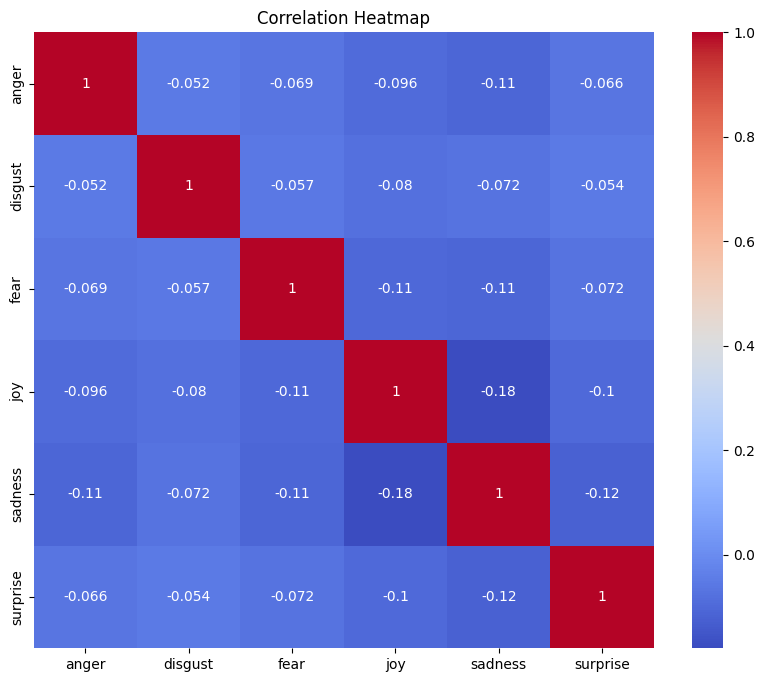


Emotion Counts:
anger        91
disgust      64
fear        109
joy         199
sadness     278
surprise    100
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.49328038703181787
Epoch 2/5: Training Loss: 0.45518361915371375
Epoch 3/5: Training Loss: 0.4412897475465329
Epoch 4/5: Training Loss: 0.40603373150625627
Epoch 5/5: Training Loss: 0.3604812039408141
Test Accuracy: 0.6287425149700598
Test F1 Score: 0.6182300964975673
Model and tokenizer saved to /content/Model_vmw
Processing language file: ibo.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2880 non-null   object
 1   text      2880 non-null   object
 2   anger     2880 non-null   int64 
 3   disgust   2880 non-null   int64 
 4   fear      2880 non-null   int64 
 5   joy       2880 non-null   int64 
 6   sadness   2880 non-null   int64 
 7   surprise  2880 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 180.1+ KB
None

Missing Values (in Percentage):
id          0.0
text        

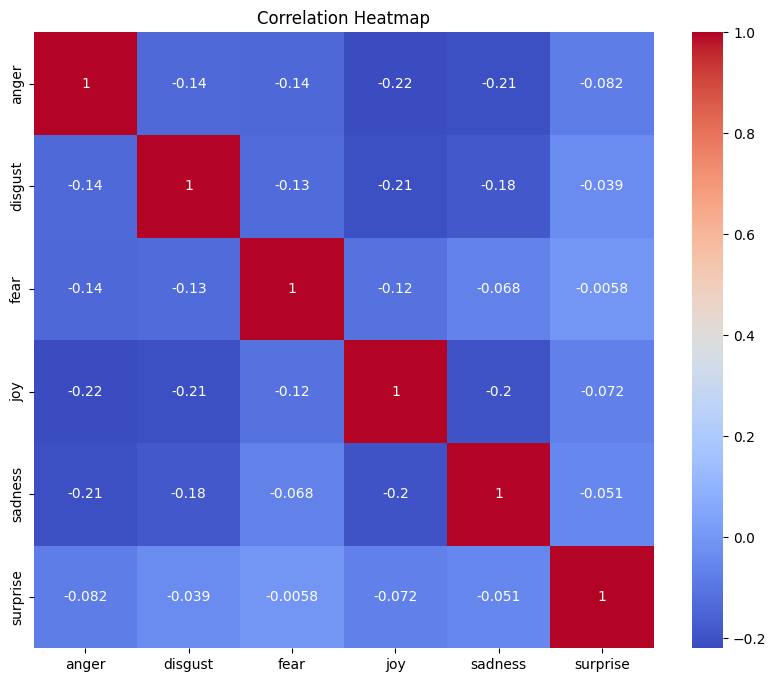


Emotion Counts:
anger       578
disgust     538
fear        219
joy         467
sadness     493
surprise     75
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: Training Loss: 0.4898942623942317
Epoch 2/5: Training Loss: 0.4242885584274699
Epoch 3/5: Training Loss: 0.33148282439976673
Epoch 4/5: Training Loss: 0.2510808977252812
Epoch 5/5: Training Loss: 0.19940177885874547
Test Accuracy: 0.7636887608069164
Test F1 Score: 0.7635204400641075
Model and tokenizer saved to /content/Model_ibo
Processing language file: pcm.csv

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3728 entries, 0 to 3727
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3728 non-null   object
 1   text      3728 non-null   object
 2   anger     3728 non-null   int64 
 3   disgust   3728 non-null   int64 
 4   fear      3728 non-null   int64 
 5   joy       3728 non-null   int64 
 6   sadness   3728 non-null   int64 
 7   surprise  3728 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 233.1+ KB
None

Missing Values (in Percentage):
id          0.0
text        0

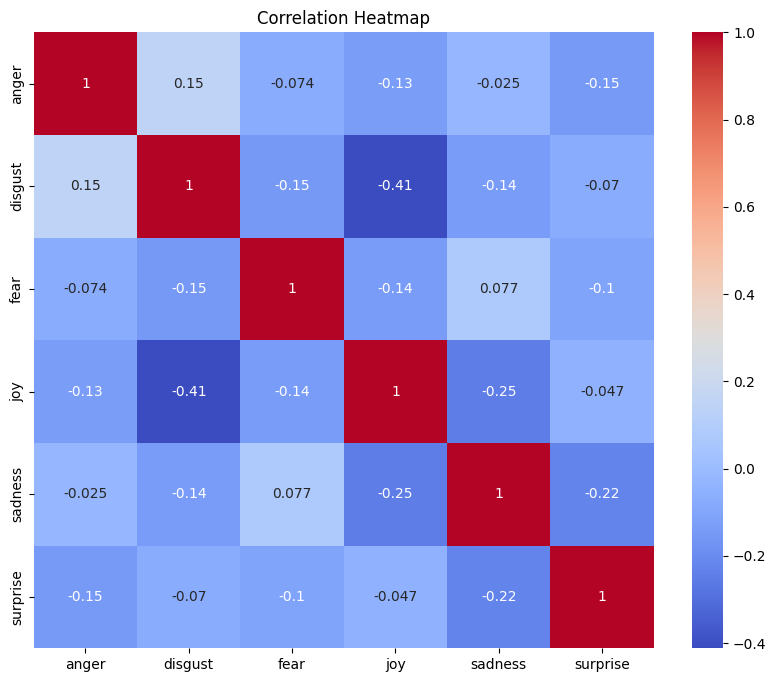


Emotion Counts:
anger        336
disgust     1885
fear         404
joy          570
sadness      986
surprise     986
dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Loop through each language file in the folder
for language_file in os.listdir(train_folder):
    if language_file.endswith('.csv'):
        # Load the dataset for the current language
        file_path = os.path.join(train_folder, language_file)
        data = pd.read_csv(file_path)

        print(f"Processing language file: {language_file}")

        # EDA (Exploratory Data Analysis)
        print("\nDataset Summary:")
        print(data.info())

        # Missing values percentage
        missing_values = data.isnull().sum()
        print("\nMissing Values (in Percentage):")
        missing_percentage = (missing_values / len(data)) * 100
        print(missing_percentage)

        # Correlation Heatmap (for numerical data)
        plt.figure(figsize=(10, 8))
        sns.heatmap(data[emotion_columns].corr(), annot=True, cmap="coolwarm")
        plt.title("Correlation Heatmap")
        plt.show()

        # Count the number of non-zero entries for each emotion
        emotion_counts = data[emotion_columns].sum()
        print("\nEmotion Counts:")
        print(emotion_counts)

        # Data Augmentation with Synthetic Data (synonym replacement)
        nltk.download('wordnet')
        data['augmented_text'] = data['text'].apply(lambda x: synonym_replacement(x, 2))

        # Preprocessing the text data
        data['processed_text'] = data['augmented_text'].apply(preprocess_text)

        # Step 3: Resampling to balance classes
        data_balanced = pd.DataFrame()
        for emotion in emotion_columns:
            class_data = data[data[emotion] == 1]
            balanced_class_data = resample(class_data, replace=True, n_samples=data[emotion_columns].sum().max(), random_state=42)
            data_balanced = pd.concat([data_balanced, balanced_class_data])

        data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

        # Step 4: Train-Test Split
        X = data_balanced['text']
        y = data_balanced[emotion_columns]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Tokenization with Hugging Face Tokenizer
        tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

        def tokenize_function(examples):
            return tokenizer(examples.tolist(), padding='max_length', truncation=True, max_length=128)

        X_train_tokens = tokenize_function(X_train)
        X_test_tokens = tokenize_function(X_test)

        # Step 5: Model Training using XLM-Roberta
        model = XLMRobertaForSequenceClassification.from_pretrained(
            'xlm-roberta-base',
            num_labels=6,
            problem_type='multi_label_classification'
        )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Optimizer
        optimizer = AdamW(model.parameters(), lr=1e-5)

        # Prepare datasets
        train_dataset = TensorDataset(
            torch.tensor(X_train_tokens['input_ids'], dtype=torch.long),
            torch.tensor(X_train_tokens['attention_mask'], dtype=torch.long),
            torch.tensor(y_train.values, dtype=torch.float)
        )

        test_dataset = TensorDataset(
            torch.tensor(X_test_tokens['input_ids'], dtype=torch.long),
            torch.tensor(X_test_tokens['attention_mask'], dtype=torch.long),
            torch.tensor(y_test.values, dtype=torch.float)
        )

        train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=8)

        # Training Loop
        epochs = 5
        for epoch in range(epochs):
            model.train()
            total_loss, total_f1, total_accuracy = 0, 0, 0
            for batch in train_dataloader:
                b_input_ids, b_attention_mask, b_labels = [item.to(device) for item in batch]
                optimizer.zero_grad()
                outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels.float())
                loss = outputs.loss
                logits = outputs.logits
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                predictions = (torch.sigmoid(logits) >= 0.5).cpu().numpy()
                total_f1 += f1_score(b_labels.cpu().numpy(), predictions, average='macro', zero_division=0)
                total_accuracy += accuracy_score(b_labels.cpu().numpy(), predictions)

            print(f"Epoch {epoch+1}/{epochs}: Training Loss: {total_loss/len(train_dataloader)}")

        # Validation and Evaluation
        model.eval()
        predictions, true_labels = [], []

        with torch.no_grad():
            for batch in test_dataloader:
                b_input_ids, b_attention_mask, b_labels = [item.to(device) for item in batch]
                outputs = model(b_input_ids, attention_mask=b_attention_mask)
                logits = outputs.logits
                predicted_emotions = torch.argmax(torch.sigmoid(logits), dim=1).cpu().numpy()
                predictions.extend(predicted_emotions)
                true_labels.extend(torch.argmax(b_labels, dim=1).cpu().numpy())

        print("Test Accuracy:", accuracy_score(true_labels, predictions))
        print("Test F1 Score:", f1_score(true_labels, predictions, average='macro'))

        # Save model and tokenizer
        model_save_path = f"/content/Model_{language_file.split('.')[0]}"
        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        print(f"Model and tokenizer saved to {model_save_path}")